# Wikipedia Movie Plots

Our [dataset](https://www.kaggle.com/jrobischon/wikipedia-movie-plots) contains plot descriptions for 34,886 movies scraped from Wikipedia. Our first goal is to predict movie genre based on just the plot description. However, we may also include some of the other variables if needed.

In [1]:
from pathlib import Path
from urllib.parse import unquote

import numpy as np
import pandas as pd
import plotly.express as px
import spacy
from sklearn.cluster import SpectralClustering
from umap import UMAP

In [2]:
# Load English tokenizer, tagger, parser and NER
# TODO: may require multiple languages
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf")

In [3]:
# Read data
df = pd.read_csv("wiki_movie_plots_deduped.csv")
df

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


Several observations can be made from the printed 10 rows:

1. There are missing values, potentially a lot of them. Most obvious ones are the `NaN`'s in `Cast`, but we also have "unknown"'s in `Director` and `Genre`.
2. A movie could have multiple directors, cast members and genres. We have a multi-label classification problem.
3. Text need to be cleaned! For example, "Director: " should be removed from entry 34881. Only one separator should be used, as now we have `,`, `\r\n`, `;`, etc.
4. `Wiki Page` seems like metadata that we could simply drop from the table.
5. Special characters (or rather, non-alphabetical characters) exist in the text, so models trained specifically on English text may not suffice.

The package [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling) could be used to explore the data, although it's more suitable for continuous variables.

```python
from pandas_profiling import ProfileReport
profile = ProfileReport(dat)
profile.to_notebook_iframe()
```

## Data cleaning

Variables `Release Year` and `Title` can be used as-is (assuming we even use them in our model). Note that `Title` may contain non-English characters.

### Origin/Ethnicity

We will start with the easiest variable `Origin/Ethnicity`. By easiest I mean it has the lowest cardinality and is mostly clean. 

In [4]:
# Check unique values in Origin/Ethnicity
print(
    f"Total missing entries in Origin/Ethnicity: {df['Origin/Ethnicity'].isna().sum()}"
)
print(f"Number of unique values: {df['Origin/Ethnicity'].nunique()}")
df["Origin/Ethnicity"].value_counts()

Total missing entries in Origin/Ethnicity: 0
Number of unique values: 24


American        17377
British          3670
Bollywood        2931
Tamil            2599
Telugu           1311
Japanese         1188
Malayalam        1095
Hong Kong         791
Canadian          723
Australian        576
South_Korean      522
Chinese           463
Kannada           444
Bengali           306
Russian           232
Marathi           141
Filipino          128
Bangladeshi        87
Punjabi            84
Malaysian          70
Turkish            70
Egyptian           67
Assamese            9
Maldivian           2
Name: Origin/Ethnicity, dtype: int64

It seems the dataset contains predominately (49.81%) American movies. Indian movies also take a large proportion, but they are separated into different ethnic groups or languages in this dataset, namely `Telugu`, `Malayalam`, `Kannada`, `Marathi`, and `Assamese`. We could consider combining them since there's still 24 unique values for this variable. We may also consider pooling some of the levels with very few observations together into an "Other" group.

### Director

Next up we have the `Director` variable, which is a lot harder to clean. A good way to extract the entries with dirty data is to filter for characters that we don't expect to see in this column. We will run this following line iteratively after cleaning some of the identified bad data. The following steps were applied sequentially to clean this column:

1. Strip whitespace from the beginning and end of the strings.
2. Remove additional information given in parentheses. These are mostly the role of the person.
3. Replace the alias "[Alan Smithee](https://en.wikipedia.org/wiki/Alan_Smithee)" with "Unknown".
4. Use `|` as separators for multiple directors. There's a mixture of `,`, `&`, `/`, `;` among others in the original dataset.
5. Remove the "Director: " string that comes before names in some cases.
6. Remove two awards strings that accompany names in very few cases.
7. Replace entries like "3 directors" with "Unknown".
8. Remove footnotes, e.g. in `Ernst Lubitsch[19]`.
9. Replace all "Unknown" entries with `NaN`.

In [5]:
df[df.Director.str.contains(r"[^\w ,.\-\"\']")]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
35,1910,The Wonderful Wizard of Oz,American,Otis Turner (unconfirmed),Bebe Daniels,unknown,https://en.wikipedia.org/wiki/The_Wonderful_Wi...,"In Kansas, Dorothy and Imogene the cow are cha..."
304,1919,When the Clouds Roll By,American,Victor Fleming & Theodore Reed,"Douglas Fairbanks, Kathleen Clifford",comedy,https://en.wikipedia.org/wiki/When_the_Clouds_...,"As described in a film magazine,[3] Daniel Boo..."
2130,1936,San Francisco,American,W. S. Van Dyke (Best Director nominee),"Clark Gable, Jeanette MacDonald, Spencer Tracy...","drama, adventure",https://en.wikipedia.org/wiki/San_Francisco_(1...,The film opens with two men in boxing gloves a...
2853,1940,Knock Knock,American,Walter Lantz (producer),NaN,animated short,https://en.wikipedia.org/wiki/Knock_Knock_(194...,The cartoon ostensibly stars Andy Panda (voice...
2933,1940,The Shop Around the Corner,American,Ernst Lubitsch[19],"James Stewart, Margaret Sullavan",romantic comedy,https://en.wikipedia.org/wiki/The_Shop_Around_...,Alfred Kralik (James Stewart) is the top sales...
...,...,...,...,...,...,...,...,...
34849,2010,Black Dogs Barking,Turkish,Mehmet Bahadır Er & Maryna Gorbach,"Cemal Toktaş, Volga Sorgu & Erkan Can",drama,https://en.wikipedia.org/wiki/Black_Dogs_Barking,Selim’s family has migrated from Anatolia to İ...
34878,2014,Mandıra Filozofu,Turkish,Director: Müfit Can Saçıntı,Director: Müfit Can Saçıntı\r\nCast: Rasim Özt...,unknown,https://en.wikipedia.org/wiki/Mand%C4%B1ra_Fil...,Cavit an ambitious industralist in İstanbul pl...
34879,2014,Winter Sleep,Turkish,Director: Nuri Bilge Ceylan,Director: Nuri Bilge Ceylan\r\nCast: Haluk Bil...,unknown,https://en.wikipedia.org/wiki/Winter_Sleep_(film),"Aydın, a former actor, owns a mountaintop hote..."
34880,2014,Sivas,Turkish,Director: Kaan Müjdeci,Director: Kaan Müjdeci\r\nCast: Dogan Izci,unknown,https://en.wikipedia.org/wiki/Sivas_(film),The film follows an eleven-year-old boy named ...


In [6]:
df["Director"] = df["Director"].str.strip()

# Info in parentheses: unconfirmed, producer, co-director, uncredited, old...
df["Director"] = df["Director"].str.replace(r"\s+\((.*?)\)", "", regex=True)
df["Director"] = df["Director"].str.replace(r"\s+\([dD]irector", "", regex=True)
df.loc[df.Director.str.match(r'"?Alan Smithee"?'), "Director"] = "Unknown"

# Uniform separators for multiple directors
df["Director"] = df["Director"].str.replace(r"\s*([,&;/]| and )\s*", " | ", regex=True)
df["Director"] = df["Director"].str.replace(
    r" \| $", "", regex=True
)  # trailing separator

# Extra information in the names
# Director(s): xxx
df["Director"] = df["Director"].str.replace(r"^Director[s]?:\s*", "", regex=True)
# Awards: Academy Award for Best Director, Best Director nominee
df["Director"] = df["Director"].str.replace(r" (Best|Academy).*$", "", regex=True)
# Another special case that I don't want to write a regex
df.loc[
    df.Title == "Veeraadhi Veeran Dubbed from Telugu", "Director"
] = "B. Vittalacharya"

# 3 directors, Six directors, ...
df.loc[df.Director.str.contains(r"[dD]irectors$"), "Director"] = "Unknown"

# Footnotes
df["Director"] = df["Director"].str.replace(r"\[\d+\]", "", regex=True)

# "Unknown" is an indicator for missing values
df.loc[df.Director == "Unknown", "Director"] = np.nan

After all this cleaning, let's see if there's any other special characters that we missed.

In [7]:
df[df.Director.notna() & df.Director.str.contains(r"[^\w \|.\-\"\']")]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
21171,2011,Dimensions,British,Sloane U’Ren,Director: Sloane U’Ren\r\nCast: Henry Lloyd-Hu...,unknown,https://en.wikipedia.org/wiki/Dimensions_(film),"The film follows Stephen, a brilliant young sc..."
28223,2011,Kottarathil Kuttibhootham (കൊട്ടാരത്തിൽ കുട്ടി...,Malayalam,Kumar Nanda – Basheer,"Mukesh, Jagadish","comedy, fantasy",https://en.wikipedia.org/wiki/Kottarathil_Kutt...,Kottarathil Kutty Bhootham tells the story of ...
29410,1968,Uyarndha Manithan,Tamil,Krishnan–Panju,"Sivaji Ganesan, Sowcar Janaki, Vanisri, Sivaku...",unknown,https://en.wikipedia.org/wiki/Uyarndha_Manithan,Rajalingam (alias Raju) (Sivaji Ganesan) is th...
29432,1970,Engal Thangam,Tamil,Krishnan–Panju,"M. G. Ramachandran, Jayalalithaa, A. V. M. Raj...",unknown,https://en.wikipedia.org/wiki/Engal_Thangam,The capital of the Tamil Country at the end of...
29459,1971,Rangarattinam,Tamil,Krishnan–Panju,"Gemini Ganesan, Sowcar Janaki, K. A. Thangavelu",unknown,https://en.wikipedia.org/wiki/Rangarattinam,A girl loses her mental balance while riding a...
29471,1972,Idhaya Veenai,Tamil,Krishnan–Panju,"M. G. Ramachandran, Manjula, Sivakumar, Lakshmi",unknown,https://en.wikipedia.org/wiki/Idhaya_Veenai,"Somewhere in Chennai, several years previously..."
29481,1972,Pillaiyo Pillai,Tamil,Krishnan–Panju,"M. K. Muthu, Lakshmi, R. S. Manohar, C. R. Vij...",unknown,https://en.wikipedia.org/wiki/Pillaiyo_Pillai,The story deals with a villain Ganngatharan(R....
29494,1973,Pookari,Tamil,Krishnan–Panju,"M. K. Muthu, Manjula, Vennira Aadai Nirmala, J...",unknown,https://en.wikipedia.org/wiki/Pookari,Valli (Manjula) is a flower seller and her bro...
29505,1974,Kaliyuga Kannan,Tamil,Krishnan–Panju,"Jaishankar, Sowcar Janaki, Jayachitra, Thengai...",unknown,https://en.wikipedia.org/wiki/Kaliyuga_Kannan,Kaliyuga Kannan is a drama of faith and disbel...
29544,1977,Chakravarthy,Tamil,Krishnan–Panju,"Jaishankar, Sharada, Sripriya, Sreekanth, Then...",unknown,https://en.wikipedia.org/wiki/Chakravarthy_(19...,"Chakravarthy, a rich boy; Ranjit, a criminal's..."


Only `–`, `=` and `’`, but they don't affect our analyses so I'm good with this.

### Cast

The `Cast` column is very similar to the `Director` column, with a few additional cases.

1. There's the Windows newline character `\r\n` that's sometimes used as a separator, and sometimes just as a space.
2. There's also the `U+00a0` Unicode space character.
3. Both `unknown` and ␣ were present as missing values.
4. Parentheses and square brackets were appearing randomly. Sometimes not even paired.

In [8]:
# Misplaced information
df.loc[df.Title == "Marwencol", "Cast"] = "Unknown"  # plot in cast

# Remove newline characters
df["Cast"] = df["Cast"].str.strip()
df["Cast"] = df["Cast"].str.replace(r",?\r\n", ", ", regex=True)
df["Cast"] = df["Cast"].str.replace(u"\xa0", " ", regex=True)

# Role inside parentheses: director, screenplay, cameo, in dual role, ...
df["Cast"] = df["Cast"].str.replace(r"\(+(.*?)\)+", "", regex=True)

# Footnotes
df["Cast"] = df["Cast"].str.replace(r"\[\d+\]", "", regex=True)
df["Cast"] = df["Cast"].str.replace(r"(\[|\])*", "", regex=True)

# Normalize separators
df["Cast"] = df["Cast"].str.replace(r"\s*([&;/,]| and )\s*", " | ", regex=True)
df["Cast"] = df["Cast"].str.replace(r"( \| )+$", "", regex=True)

# Annotation of people
df["Cast"] = df["Cast"].str.replace(
    r"(Director|Cast|Introducing)s?:\s*", "", regex=True
)

# Fix missing values and split cast
df.loc[(df.Cast.str.match(r"^\s*$")) | (df.Cast == "Unknown"), "Cast"] = np.nan
# dat["Cast"] = dat["Cast"].str.split(", ")

Finally there's a **big** difference -- in some entries the `Genre` of the movie was given in the `Cast` column! Often times these entries have `unknown` genres or some random values.

In [9]:
df[df.Cast.notna() & df.Cast.str.contains(r"[Cc]omedy|[Rr]omantic|[Mm]usical")].head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
80,1914,Charlie Chaplin,American,Charlie Chaplin | Mabel Normand,Comedy,unknown,https://en.wikipedia.org/wiki/His_Trysting_Place,Charlie and his friend Ambrose meet in a resta...
17255,2017,Roadside Attractions,American,NaN,Comedy | Drama,"usa, can",https://en.wikipedia.org/wiki/Beatriz_at_Dinner,The film opens with Beatriz (Salma Hayek) rowi...
17294,2017,Bleecker Street / FilmNation Entertainment,American,NaN,Heist | Comedy,usa,https://en.wikipedia.org/wiki/Logan_Lucky,Jimmy Logan is laid off from his construction ...
21089,2010,Edgar Wright,British,Michael Cera | Mary Elizabeth Winstead | Ellen...,Romantic comedy,august 25,https://en.wikipedia.org/wiki/Scott_Pilgrim_vs...,"In Toronto, 23-year-old Scott Pilgrim is a bas..."
23242,1988,Stanley Kwan,Hong Kong,Leslie Cheung | Anita Mui,Romantic fantasy,unknown,https://en.wikipedia.org/wiki/Rouge_(film),"In 1980s Hong Kong, newspaperman Yuen (Alex Ma..."


And the problem is bigger than we thought. This probably explains why we have movies that were directed by so many people. The entire row was shifted -- `Director` is in `Title`, `Cast` is in `Director`, and `Genre` is in `Cast`.

### Wiki Page

One possible way to mitigate this issue is to parse the last part of the URL in `Wiki Page`. If the extracted values don't match the value in `Title`, then we *may* have a shift in columns. We first separate the dataset into two tables -- the "good" table where `Title` and `Wiki Page` are exact matches, and the "bad" table where there is an mismatch. Then we investigate the mismatches and hopefully find a fix for some of the movies with unknown genres.

In [10]:
# Parse the percent-encoded string in the URLs
df["Wiki Title"] = df["Wiki Page"].str.replace("_", " ")
df["Wiki Title"] = df["Wiki Title"].apply(lambda x: unquote(x.split("/")[-1]))

# Remove (YYYY film) in links and titles
df["Wiki Title"] = df["Wiki Title"].str.replace(r"\s*\((\d+ )?film\)", "", regex=True)
df["Title"] = df["Title"].str.replace(r"\s*\((\d+ )?film\)", "", regex=True)

## Genres

There's **way** too many genres in this dataset. Fortunately we will soon see that a lot of these are not actually genres -- some are misplaced strings, some are detailed descriptions, and some are simply uninterpretable.

In [11]:
df.Genre.unique().shape[0]

2265

### Genres in Cast

We first fix the genres stored in the `Cast` column. Recall that when the genre is in `Cast`, the corresponding value in `Genre` is not always `unknown`, so we can't simply take the approach below:

```sql
SELECT * FROM df WHERE
    Genre = 'unknown' AND
    Cast IS NOT NULL
```

Instead, we need a way to figure out all the values in `Genre` that are probably not, well, genres. A simple way to do this is to start from a genre that's known to be in the `Cast` column, e.g. "comedy". Bacause certain movies are tagged "comedy" along with some other genre (e.g. "romance"), we can repeat this process iteratively to find tokens that are probably genres in the column.

In [12]:
def find_related_genres(cast_col: pd.Series, regex: str):
    related_genres = (
        cast_col[cast_col.str.contains(regex, regex=True, case=False)]
        .apply(lambda x: x.split(" | "))
        .explode()
    )
    related_genres = related_genres[
        ~related_genres.str.contains(regex, regex=True, case=False)
    ]
    return related_genres.unique()


genres_in_cast = {"comedy"}
all_casts = df.Cast[(df.Cast.notna()) & (df.Title != df["Wiki Title"])]
# Filter out some edge cases
all_casts = all_casts[~all_casts.str.contains("Thriller Manju", regex=False)]
all_casts = all_casts[~all_casts.str.contains("Love", regex=False)]

while True:
    regex = rf"\b(?:{'|'.join(genres_in_cast)})\b"
    related_genres = find_related_genres(all_casts, regex)
    related_genres = [x.lower() for x in related_genres]
    if len(related_genres) == 0:
        break

    genres_in_cast = genres_in_cast.union(related_genres)

genres_in_cast

{'action',
 'comedy',
 'crime',
 'drama',
 'entered into the 11th moscow international film festival',
 'family',
 'fantasy',
 'heist',
 'historical',
 'horror',
 'musical',
 'romance',
 'social',
 'sports',
 'suspense',
 'thriller',
 'war'}

This isn't bad! We just need to remove the one false positive and get all the entries matching those genres. There's a total of 68 entries in this dataset matching the following criteria.

In [13]:
genres_in_cast.remove("entered into the 11th moscow international film festival")
regex = rf"\b(?:{'|'.join(genres_in_cast)})\b"

bad_genre = (
    df.Cast.notna()
    & df.Cast.str.contains(regex, regex=True, case=False)
    & (~df.Title.isin(["Jaihind", "51 Birch Street"]))
)

df.loc[bad_genre, "Genre"] = df["Cast"]
df.loc[bad_genre, "Cast"] = df["Director"]
df.loc[bad_genre, "Director"] = df["Title"]
df.loc[bad_genre, "Title"] = df["Wiki Title"]

Now we run some basic cleaning on the `Genre` column that can be catched by glimpsing sample rows.

In [14]:
df["Genre"] = df["Genre"].str.replace(u"\xa0", " ", regex=False)
df["Genre"] = df["Genre"].str.strip()

# Remove footnotes
df["Genre"] = df.Genre.str.replace("\s*\[.*\]", "", regex=True)

# One dash to rule them all
df["Genre"] = df["Genre"].str.replace("–|—", "-", regex=True)
df.loc[df.Genre.isin(["-", ""]), "Genre"] = "unknown"

# Trailing punctuation
df["Genre"] = df["Genre"].str.replace("[.,;\s]+$", "", regex=True)

# I don't care who produced it
df["Genre"] = df["Genre"].str.replace(
    "(warner bros|paramount|united artists)\. ", "", regex=True
)
df["Genre"] = df["Genre"].str.replace("(co-)?produced .*$", "", regex=True)

df.loc[df.Genre.str.contains("films$"), "Genre"] = "unknown"
df["Genre"] = df["Genre"].str.replace("\s*film\s*", "", regex=True)

# or what the movie is based on
df["Genre"] = df["Genre"].str.replace(" (about|based on).*$", "", regex=True)

# or info in parentheses. There's some cases where the sport is annotated,
# but I don't think dividing the sports genre into multiple groups would help
df["Genre"] = df["Genre"].str.replace(r"\s*\(.*?\)\s*", "", regex=True)

# Different name same meanings
df["Genre"] = df["Genre"].str.replace("3-d", "3d", regex=False)
df["Genre"] = df["Genre"].str.replace("science[- ]fiction", "sci-fi", regex=True)
df["Genre"] = df["Genre"].str.replace("sci fi", "sci-fi", regex=False)
df["Genre"] = df["Genre"].str.replace(r"bio-?pic", "biographical", regex=True)
df["Genre"] = df["Genre"].str.replace("biography", "biographical", regex=False)
df["Genre"] = df["Genre"].str.replace("ww|(world war)", " worldwar", regex=True)
df["Genre"] = df["Genre"].str.replace(r"(kung|gun)( |-)fu", "kungfu", regex=True)
df["Genre"] = df["Genre"].str.replace("007", "james bond", regex=False)
df["Genre"] = df["Genre"].str.replace(
    r"rom(antic|ance)? com(edy)?", "rom-com", regex=True
)
df["Genre"] = df["Genre"].str.replace(
    r"(action|comedy|horror) masala", r"\1 | masala", regex=True
)

# Typos
df["Genre"] = df["Genre"].str.replace("family. ", "family | ", regex=False)
df["Genre"] = df["Genre"].str.replace("familya", "family", regex=False)
df["Genre"] = df["Genre"].str.replace("supeheroes", "superheroes", regex=False)
df["Genre"] = df["Genre"].str.replace(r" in 3d.?", ", 3d", regex=True)

# Special cases
df.loc[df.Title == "Tales of Manhattan", "Genre"] = "drama | comedy"
df.loc[df.Title == "Aaram", "Genre"] = "romance"
df.loc[df.Title == "Roadside Attractions", "Genre"] = "comedy | drama"

# Separators
df["Genre"] = df["Genre"].str.replace(r"\s*([;,/]| and )\s*", " | ", regex=True)
df["Genre"] = df["Genre"].str.replace(r"\s+[&-]\s+", " | ", regex=True)
df["Genre"] = df["Genre"].str.replace(r"( \| )+$", "", regex=True)

### Embeddings

There's so many more edge cases and since nobody wants to go through thousands of entries manually, we may project the values into some embedding space and find clusters, in hope that actual genres will be close to each other. To make visualization easier, we first used `SpaCy` to covert the unique tokens into vectors, and then used `UMAP` to reduce the 768-dimensional vector to two dimensions. Spectral clustering was then performed for coloring the points.

In [38]:
df_genres = (
    df.reset_index()
    .rename(columns={"index": "movieID"})
    .assign(
        Genre=lambda dat: dat["Genre"].apply(lambda x: x.lower().split(" | ")),
    )
    .explode("Genre")
    .filter(["movieID", "Genre"])
)

In [39]:
# Save UMAP results because it's not deterministic
f_umap = Path("genre_umap_projections.csv")
if f_umap.is_file():
    genre_proj = pd.read_csv(f_umap)
    genre_proj.Cluster = genre_proj.Cluster.astype(str)
else:
    # Get unique genre tokens
    genres = df_genres.Genre.unique().tolist()

    # Lemmatize tokens
    doc = nlp.pipe(genres)
    genre_lemma = [" ".join([x.lemma_.strip() for x in token]) for token in doc]
    genre_lemma = pd.Series(genre_lemma)
    genre_lemma = genre_lemma.str.replace(r"\s*([\-.'])\s*", r"\1", regex=True)

    # Get embeddings using default SpaCy transformer model
    doc = nlp.pipe(genre_lemma)
    genre_vecs = [token._.trf_data.tensors[-1].flatten() for token in doc]

    # Reduce the dimensions of embedding tensors with UMAP
    umap_2d = UMAP(n_components=2, learning_rate=0.5, init="spectral", random_state=42)
    proj_2d = umap_2d.fit_transform(genre_vecs)

    # Spectral clustering on the projections
    sc = SpectralClustering(n_clusters=10, random_state=42)
    genre_clust = sc.fit_predict(proj_2d).astype(str)

    # Concatenate results in a data frame
    genre_proj = pd.DataFrame(
        {
            "Genre": genres,
            "GenreLemma": genre_lemma,
            "Cluster": genre_clust,
            "UMAP0": proj_2d[:, 0],
            "UMAP1": proj_2d[:, 1],
        }
    )
    genre_proj = genre_proj.sort_values(["Cluster", "GenreLemma"])
    genre_proj.to_csv(f_umap, index=False)

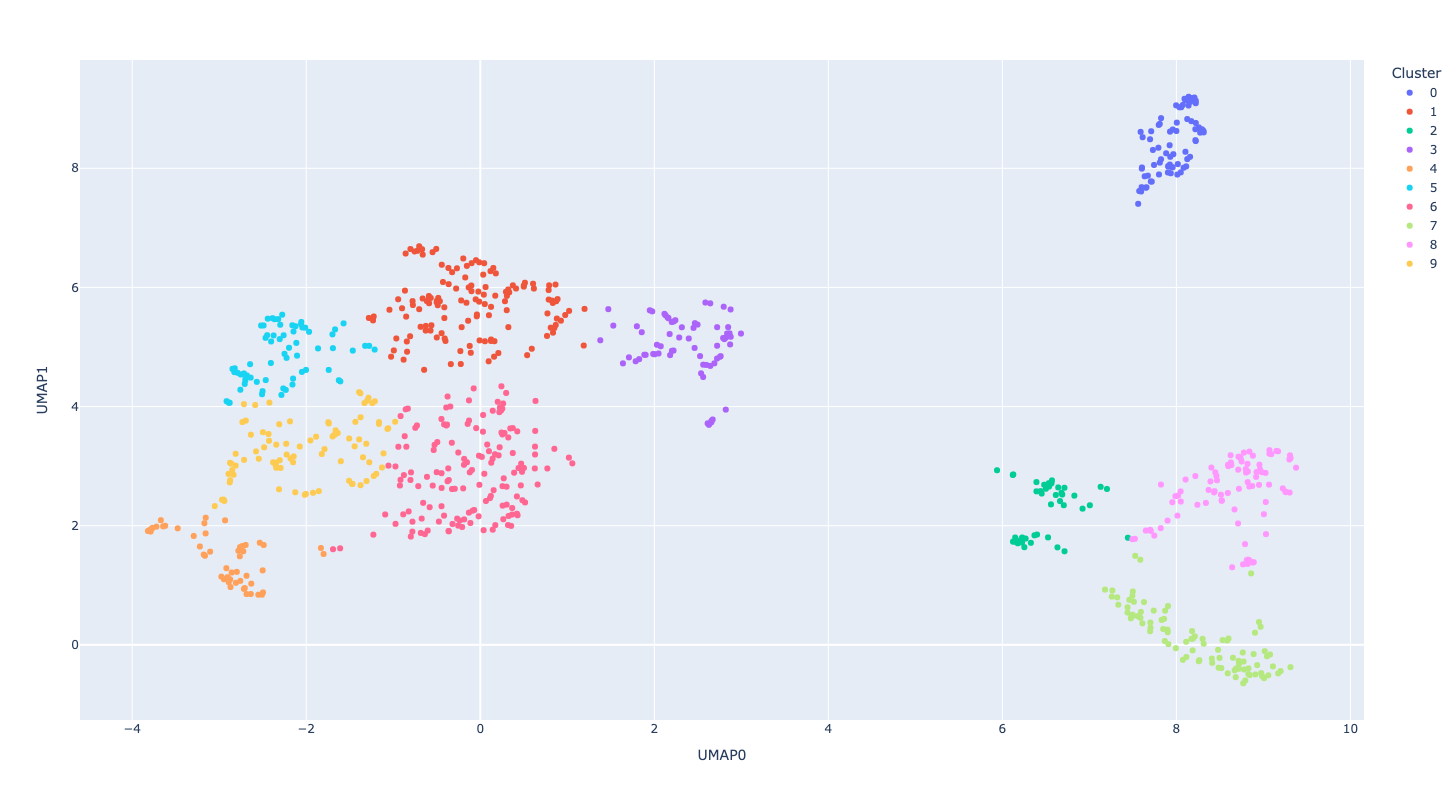

In [40]:
fig = px.scatter(
    genre_proj,
    x="UMAP0",
    y="UMAP1",
    hover_name="GenreLemma",
    color="Cluster",
    width=1000,
    height=800,
)
fig.show()

We have three big clusters, namely $A = \{0\}$, $B = \{2, 7, 8\}$, and $C = \{1, 3, 4, 5, 6, 9\}$. Cluster 0 contains mostly names and unrecognizable strings, so **we may drop these entries**. Cluster $B$ contains mostly single-word strings. Cluster 8 contains a lot of typos (**fix**), but also some valid genres (**keep**) and some names (**replace with unknown**). Clusters 2 and 7 contains mostly valid single-word genres, with a few expectations like `sword` and `p.o.w`.

As for Cluster $C$, things are a bit more complicated. These are typically longer strings ranging from two to five words. Some are multiple genres separated by spaces, so our previous regexs didn't separate them successfully. We also have some companies and very specific descriptions mixed in here, e.g. `biographical of pioneering american photographer eadweard muybridge`.

### Dimension reduction on genres
So let's try to fix this! We first join the table with the full dataset to get the lemmatized genres for each movie.

In [41]:
df_genres = (
    df_genres.merge(genre_proj, on="Genre")
    .assign(Genre=lambda x: x["GenreLemma"])
    .drop(columns="GenreLemma")
)
df_genres.head()

,movieID,Genre,Cluster,UMAP0,UMAP1
0,0,unknown,2,6.368839,1.837754
1,1,unknown,2,6.368839,1.837754
2,2,unknown,2,6.368839,1.837754
3,3,unknown,2,6.368839,1.837754
4,4,unknown,2,6.368839,1.837754


Upon inspection, only three strings from Cluster 0 are genres, so we drop everything else.

In [42]:
# Drop all those genres from Cluster 0 that don't make sense
clust0_unknown_movies = df_genres[df_genres.Cluster == "2"]
clust0_unknown_movies = clust0_unknown_movies.loc[
    ~clust0_unknown_movies.Genre.isin(["james bond", "buddy cop", "crime ttriller"]),
    "movieID",
]
df_genres.loc[df_genres.movieID.isin(clust0_unknown_movies), "Genre"] = "unknown"

Cluster 8 is more complicated - we have a mixture of genres, typos and random names. Luckily a lot of the names cluster together, so we can remove them based on the UMAP projections. Interestingly, the projection of `unknown` also falls here. Finally, we manually write some invalid genres in an external file.

In [59]:
with open("invalid_genres.txt", "r") as f:
    invalid_genres = [x.strip() for x in f.readlines()]

In [72]:
# Fix typos from Cluster 8
df_genres["Genre"] = df_genres["Genre"].str.replace(
    "ttriller|thriler|triller", "thriller", regex=True, case=False
)
df_genres["Genre"] = df_genres["Genre"].str.replace(
    "biogtaphy", "biography", regex=False
)
df_genres["Genre"] = df_genres["Genre"].str.replace("slahser", "slasher", regex=False)
df_genres["Genre"] = df_genres["Genre"].str.replace("fantay", "fantasy", regex=False)
df_genres["Genre"] = df_genres["Genre"].str.replace("tragerdy", "tragedy", regex=False)
df_genres["Genre"] = df_genres["Genre"].str.replace("comedey", "comedy", regex=False)
df_genres["Genre"] = df_genres["Genre"].str.replace("romcom", "rom-com", regex=False)
df_genres.loc[df_genres.Genre.isin(["erotica", "ero"]), "Genre"] = "erotic"

names_mask = (
    (df_genres.Cluster == "8")
    & (df_genres.UMAP0 > 8.5)
    & (df_genres.UMAP1 > 2.7)
    & (df_genres.Genre != "operetta")
)
df_genres.loc[names_mask, "Genre"] = "unknown"
df_genres.loc[df_genres.Genre.isin(invalid_genres), "Genre"] = "unknown"  # not just 8

In [78]:
# Just a few special cases in Cluster 7
df_genres["Genre"] = df_genres["Genre"].str.replace("period", "historical", regex=False)
df_genres["Genre"] = df_genres["Genre"].str.replace("p.o.w", "pow", regex=False)

array(['comedy', 'unknown', 'drama', 'adventure', 'horror', 'crime',
       'fantasy', 'mystery', 'romance', 'exploitation', 'propaganda',
       'melodrama', 'documentary', 'family', 'war', 'thriller', 'race',
       'action', 'sport', 'animation', 'music', 'suspense', 'cartoon',
       'aviation', 'docudrama', 'nature', 'espionage', '3d', 'pow',
       'trilogy', 'sexploitation', 'disaster', 'travel', 'compilation',
       'parody', 'anthology', 'mockumentary', 'blaxploitation',
       'priquitianism', 'student', 'reality', 'history', 'dramedy',
       'silent', 'dance', 'concert', 'road', 'survival', 'boxing',
       'heist', 'surf', 'counterculture', 'punk', 'historical', 'kungfu',
       'biodrama', 'sf', 'tragedy', 'kid', 'costume', 'child', 'sword',
       'bruceploitation', 'prison', 'erotic', 'dev', 'mythology',
       'sentiment', 'business', 'politics', 'sex', 'love', 'art', 'youth',
       'campus', 'patriotism', 'revenge', 'critically acclaim', 'mob',
       'folklore', 'r

In [80]:
df_genres.Genre.unique().shape

(742,)

Now for Cluster $C$, we need to figure out a way to extract the space-separated genres without breaking the genres that contain spaces, i.e. multi-word genres.

In [24]:
# doc = nlp("The genre of the movie is martial arts comedy.")
# spacy.displacy.render(doc, style="ent", jupyter=True)

# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)